# Introduction

In this notebook, we present how we prepare the clean data set for analysis. We first prepare players' carear statistics based on seasonal statistics downloaded from kaggle. We then include features including Hall of Fame inductees, championships, and seasonal awards.

# Prepare Data Frame For Career Statistics

In this section, we present how we prepare NBA players' career statistics from seasonal statistics data.

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns

### Importing dataset

We first import the seasonal statistics data downed from kaggle and perform a rough cleansing. 

In [2]:
# The dataset 'Seasons_Stats.csv' is from https://www.kaggle.com/drgilermo/nba-players-stats
raw_seasonal_stats = pd.read_csv('../data/Seasons_Stats.csv',index_col=False)

# drop the first columns which is only the index
raw_seasonal_stats.drop(raw_seasonal_stats.columns[0],axis=1,inplace=True)

# delete *
raw_seasonal_stats['Player'] = raw_seasonal_stats['Player'].str.replace('*','')

# delete blank columns
raw_seasonal_stats.drop(['blanl','blank2'],axis=1,inplace = True)

In [3]:
print('--------information for seasonal_stats----------')
raw_seasonal_stats.info()

--------information for seasonal_stats----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 50 columns):
Year      24624 non-null float64
Player    24624 non-null object
Pos       24624 non-null object
Age       24616 non-null float64
Tm        24624 non-null object
G         24624 non-null float64
GS        18233 non-null float64
MP        24138 non-null float64
PER       24101 non-null float64
TS%       24538 non-null float64
3PAr      18839 non-null float64
FTr       24525 non-null float64
ORB%      20792 non-null float64
DRB%      20792 non-null float64
TRB%      21571 non-null float64
AST%      22555 non-null float64
STL%      20792 non-null float64
BLK%      20792 non-null float64
TOV%      19582 non-null float64
USG%      19640 non-null float64
OWS       24585 non-null float64
DWS       24585 non-null float64
WS        24585 non-null float64
WS/48     24101 non-null float64
OBPM      20797 non-null float64
DBPM      20797 non-

This dataset includes statistics from 1950 season to 2017 season. During this period, there are many players having the same legal names, many of them fathers and sons. To construct career statistics, we need to have the ability to distinguish each player. Motivated by the father and son situation, we create a new feature 'Birth Year' to distinguish players who have the same legal names.

In [4]:
# Create new feature 'birth_year' in All_season_stats, in order to distinguish the players with the same legal names
raw_seasonal_stats['Birth Year'] = raw_seasonal_stats['Year'] - raw_seasonal_stats['Age'] 

After reviewing the data for 1950 season, we find that there are (1) multiple entries for a single player if the player had been traded during the season, (2) there are many missing data. In the following, we are going to deal with these two problems one-by-one.

In [5]:
raw_seasonal_stats.query('Year == 1950').head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Birth Year
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,1919.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,1921.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0,1925.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0,1926.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0,1926.0


### Consolidate multiple entries for players traded during the season

For players traded during the season, their seasonal statistics is recorded under entry with feature 'Tm' labeled 'TOT.' In the following, we search for entries whose 'Tm' is labeled as 'TOT' in season by season and delete the other entries for the same players.

In [6]:
# Create new dataframe All_season_stats
# eliminae multple entry for a sginel player in one season, keeping only the TOT stats
column_list = list(raw_seasonal_stats)
temp_seasonal_stats = pd.DataFrame(columns=column_list)

for year in range(1950,2018):
    temp = raw_seasonal_stats.query('Year == ' + str(year))
    # find the entries with 'Tm' labeled as 'TOT'
    repeated_name_index = temp.index[temp.Tm == 'TOT'].tolist()
    total_list = temp.index.tolist()
    # drop the other entries with the same plaer sname and Birth Year
    drop_list = []
    for i in repeated_name_index:
        temp_list = temp.index[(temp.Player == temp.loc[i].Player) & (temp['Birth Year'] == temp.loc[i,'Birth Year']) & (temp.Tm != 'TOT')].tolist()
        if temp_list:
            # check if the repeated entries are for the same player in different teams rather then a different person
            if (sum(temp.loc[temp_list,'G']) != temp.loc[i,'G']):
                print('Year = '+ str(year) +': there are Players not distinguishable by names and birth year!')
                print(str(i)+','+temp.loc[i].Player)
                print(temp_list)
            else:
                drop_list = drop_list + temp_list

    keep_list = sorted(list(set(total_list).difference(set(drop_list))))
    single_season_states = temp.loc[keep_list]
    # Check if all the repeated entries are deleted
    if (single_season_states.groupby(['Player','Birth Year']).Tm.count()>1).sum() > 0:
        print('There are error in the codes!')

    temp_seasonal_stats = temp_seasonal_stats.append(single_season_states)
    
temp_seasonal_stats.reset_index(drop = True,inplace=True)


In [7]:
# rename temp_seasonal_stats as seasonal_stats
seasonal_stats= temp_seasonal_stats.copy()

In [8]:
seasonal_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Birth Year
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,1919.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,1921.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0,1925.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0,1926.0
4,1950.0,Ralph Beard,G,22.0,INO,60.0,NaN,NaN,NaN,0.422,...,NaN,NaN,NaN,233.0,NaN,NaN,NaN,132.0,895.0,1928.0


### Treating Missing Data

We now explore the missing data in the seasonal_stats. There are many missing data before year 1982, possibly becuase some statistics were established or not recoded at that time. For example, the 3-point line was added in 1979 resulting in the game we now recognize as basketball, and marking the Modern NBA era. If we choose only to include data from this era we can still retain 72% of player careers. Therefore, we drop the data before year 1982.

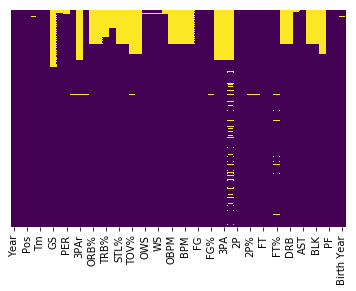

In [9]:
# the missing data are labeld in yellow
sns.heatmap(seasonal_stats.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
# Drop any data before year 1982 and store the data as part_season_stats
part_season_stats = seasonal_stats.query('Year>1981')

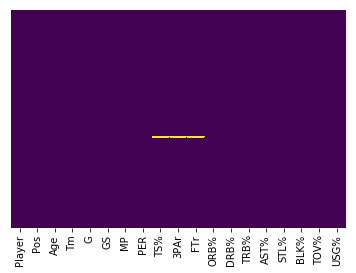

In [11]:
sns.heatmap(part_season_stats.iloc[:,1:20].isnull(),yticklabels=False,cbar=False,cmap='viridis')

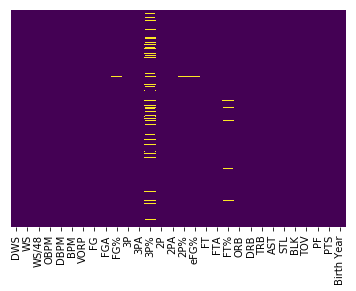

In [12]:
sns.heatmap(part_season_stats.iloc[:,21:].isnull(),yticklabels=False,cbar=False,cmap='viridis')

To study the null elements, we write the following functions and analyze the null elements one by one. We find that null elements are directly related to the elements that used as denominators in calculation and set those null elements to zero.

In [13]:
# show the null elements for part_season_stats
def show_null_elements(df):
    temp = df.isnull().sum()
    sig = 0
    for x in list(temp.index):
        if temp.iloc[:][x] > 0:
            sig=1
            print(x + ' has ' + str(temp.iloc[:][x]) + ' Null Elements')
            
    if sig == 0:
        print('There are no null elements')


In [14]:
show_null_elements(part_season_stats)

PER has 3 Null Elements
TS% has 37 Null Elements
3PAr has 44 Null Elements
FTr has 44 Null Elements
ORB% has 3 Null Elements
DRB% has 3 Null Elements
TRB% has 3 Null Elements
AST% has 3 Null Elements
STL% has 3 Null Elements
BLK% has 3 Null Elements
TOV% has 29 Null Elements
USG% has 3 Null Elements
WS/48 has 3 Null Elements
FG% has 44 Null Elements
3P% has 2448 Null Elements
2P% has 59 Null Elements
eFG% has 44 Null Elements
FT% has 408 Null Elements


Here we show that 'MP' == 0 is the reason that 'PER','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','USG%', and 'WS/48' are 'NaN,' and replace 'NaN' with 0. 

In [15]:
# if ['PER','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','USG%','WS/48'] == NaN, MP is zero 
print(part_season_stats[part_season_stats['PER'].isnull()].loc[:,['Player','MP','PER','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','USG%','WS/48']]) # it looks like PER == NaN because MP is zero
# MP is zero iff ['PER','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','USG%','WS/48'] == NaN 
print(part_season_stats[part_season_stats['MP']==0].loc[:,['Player','MP','PER','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','USG%','WS/48']]) 

              Player   MP  PER  TS%  ORB%  DRB%  TRB%  AST%  STL%  BLK%  USG%  \
15090    Alex Scales  0.0  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16636  JamesOn Curry  0.0  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
18120   Damion James  0.0  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

       WS/48  
15090    NaN  
16636    NaN  
18120    NaN  
              Player   MP  PER  TS%  ORB%  DRB%  TRB%  AST%  STL%  BLK%  USG%  \
15090    Alex Scales  0.0  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16636  JamesOn Curry  0.0  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
18120   Damion James  0.0  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

       WS/48  
15090    NaN  
16636    NaN  
18120    NaN  


In [16]:
MP_0_index = part_season_stats.index[part_season_stats['MP']==0].tolist();
columns = ['PER','TS%','ORB%','DRB%','TRB%','AST%','STL%','BLK%','USG%','WS/48']
for i in MP_0_index:
    for x in columns:
        part_season_stats.at[i,x] = 0 

print(part_season_stats.loc[MP_0_index,columns])
show_null_elements(part_season_stats)

       PER  TS%  ORB%  DRB%  TRB%  AST%  STL%  BLK%  USG%  WS/48
15090  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
16636  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
18120  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
TS% has 34 Null Elements
3PAr has 44 Null Elements
FTr has 44 Null Elements
TOV% has 29 Null Elements
FG% has 44 Null Elements
3P% has 2448 Null Elements
2P% has 59 Null Elements
eFG% has 44 Null Elements
FT% has 408 Null Elements


Here we show that '3PAr','FTr','FG%','3P%','2P%','eFG%', and 'FT%' are null elements because the corresponding denominator 'FGA','FGA','FGA','3PA','2PA','FGA', and 'FTA' are zero.

In [17]:
# the rate or percentage is NaN because the corresponding denomenator is zero
# ['3PAr','FTr','FG%','3P%','2P%','eFG%','FT%']
columns1 = ['3PAr','FTr','FG%','3P%','2P%','eFG%','FT%']
columns2 = ['FGA','FGA','FGA','3PA','2PA','FGA','FTA']

for x1 in columns1:
    x2 = columns2[columns1.index(x1)]
    null_set = set(part_season_stats.index[part_season_stats[x1].isnull()].tolist())
    zero_set = set(part_season_stats.index[part_season_stats[x2]==0].tolist())
    if null_set == zero_set:
        print(x1 + ' and ' + x2 + ': give identical results!')
    else:
        print(x1 + ' and ' + x2 + ': give different results!')
        
print('\n')

for x in columns1:
    null_index = part_season_stats.index[part_season_stats[x].isnull()].tolist()
    for i in null_index:
        part_season_stats.at[i,x] = 0 

show_null_elements(part_season_stats)

3PAr and FGA: give identical results!
FTr and FGA: give identical results!
FG% and FGA: give identical results!
3P% and 3PA: give identical results!
2P% and 2PA: give identical results!
eFG% and FGA: give identical results!
FT% and FTA: give identical results!


TS% has 34 Null Elements
TOV% has 29 Null Elements


Here we show that 'TS% is null iff 'FGA' == 0, 'FTA' == 0, and 'MP'!=0 and that 'TOV% is null iff 'FGA' == 0, 'FTA' == 0, and 'TOV'==0. 

In [18]:
# 'TS% is null iff 'FGA' == 0, 'FTA' == 0, and 'MP'!=0
null_set = set(part_season_stats.index[part_season_stats['TS%'].isnull()].tolist())
FGA_zero_set = set(part_season_stats.index[part_season_stats['FGA']==0].tolist())
FTA_zero_set = set(part_season_stats.index[part_season_stats['FTA']==0].tolist())
MP_nonzero_set = set(part_season_stats.index[part_season_stats['MP']!=0].tolist())
zero_set = FGA_zero_set.intersection(FTA_zero_set,MP_nonzero_set)

print('The two sets are the same: '+str(null_set == zero_set))

# 'TOV% is null iff 'FGA' == 0, 'FTA' == 0, and 'TOV'==0
null_set = set(part_season_stats.index[part_season_stats['TOV%'].isnull()].tolist())
FGA_zero_set = set(part_season_stats.index[part_season_stats['FGA']==0].tolist())
FTA_zero_set = set(part_season_stats.index[part_season_stats['FTA']==0].tolist())
TOV_zero_set = set(part_season_stats.index[part_season_stats['TOV']==0].tolist())
zero_set = FGA_zero_set.intersection(FTA_zero_set,TOV_zero_set)

print('The two sets are the same: '+str(null_set == zero_set))

for x in ['TS%','TOV%']:
    null_index = part_season_stats.index[part_season_stats[x].isnull()].tolist()
    for i in null_index:
        part_season_stats.at[i,x] = 0 

print('\n')
show_null_elements(part_season_stats)

The two sets are the same: True
The two sets are the same: True


There are no null elements


### Construct Data Frame For Career Statistics

We first construct features 'Year_start' and 'Year_end' out of seasonal_stats so that the features would be accurate for players who have played before 1982.

In [19]:
# The features for 'Year_start' and 'Year_end'
year_features = seasonal_stats.groupby(['Player','Birth Year'])['Year'].agg(['min','max']).reset_index().rename(index=str, columns={'min':'Year_start','max':'Year_end'})
year_features.head()

,Player,Birth Year,Year_start,Year_end
0,A.C. Green,1964.0,1986.0,2001.0
1,A.J. Bramlett,1977.0,2000.0,2000.0
2,A.J. English,1968.0,1991.0,1992.0
3,A.J. Guyton,1979.0,2001.0,2003.0
4,A.J. Hammons,1993.0,2017.0,2017.0


We then construct the player's career statistics out of seasonal statistics. However, for players who have played before 1982, some of the statistics would be inaccurate because of missing data. 

In [20]:
def career_func(df):
    # 
    df_new = pd.DataFrame()
    # total game
    df_new[['G']] = df[['G']].sum() 
    # total game start
    df_new[['GS']] = df[['GS']].sum() 
    # total minute played
    df_new['MP'] = df[['MP']].sum()  # minute per game df_new['MP'] = df.apply(lambda x: x['MP'].sum()/x['G'].sum()) 
    # 'FG': Field Goal
    df_new['FG'] = df[['FG']].sum();
    # 'FGA': Field Goal Attempt
    df_new['FGA'] = df[['FGA']].sum();
    # 'FG%': Field Goal Percentage; the formula is FG / FGA. 
    df_new['FG%'] = df.apply(lambda x: x['FG'].sum()/x['FGA'].sum() if x['FGA'].sum() > 0 else 0)
    # '3P': 3-Point Field Goals 
    df_new['3P'] = df[['3P']].sum();
    # '3PA': 3-Point Field Goal attempt
    df_new['3PA'] = df[['3PA']].sum();
    # '3P%': 3-point Field Goal Percentage
    df_new['3P%'] = df.apply(lambda x: x['3P'].sum()/x['3PA'].sum() if x['3PA'].sum() >0 else 0)
    # '2P': 2-Point Field Goals
    df_new['2P'] = df[['2P']].sum();
    # '2PA': 2-Point Field Goal attempt
    df_new['2PA'] = df[['2PA']].sum();
    # '2P%': 2-point Field Goal Percentage
    df_new['2P%'] = df.apply(lambda x: x['2P'].sum()/x['2PA'].sum() if x['2PA'].sum() >0 else 0)
    # 'eFG%': Effective Field Goal Percentage; the formula is (FG + 0.5 * 3P) / FGA.
    df_new['eFG%'] = df.apply(lambda x: (x['FG'].sum() + 0.5*x['3P'].sum())/x['FGA'].sum() if x['FGA'].sum() >0 else 0)
    # 'FT': Free Throws 
    df_new['FT'] = df[['FT']].sum();
    # 'FTA': Free Throws Attempt
    df_new['FTA'] = df[['FTA']].sum();
    # 'FT%': Free Throws Percentage
    df_new['FT%'] = df.apply(lambda x: x['FT'].sum()/x['FTA'].sum() if x['FTA'].sum() >0 else 0)
    # 'ORB': Offensive Rebound
    df_new['ORB'] = df[['ORB']].sum();
    # 'DRB': defensive Rebound
    df_new['DRB'] = df[['DRB']].sum();
    # 'TRB': total rebound 
    df_new['TRB'] = df[['TRB']].sum();
    # 'AST': Assist
    df_new['AST'] = df[['AST']].sum();
    # 'STL': Steal
    df_new['STL'] = df[['STL']].sum();
    # 'BLK': Block
    df_new['BLK'] = df[['BLK']].sum();
    # 'TOV': turnover
    df_new['TOV'] = df[['TOV']].sum();
    # 'PF': personal foul
    df_new['PF'] = df[['PF']].sum();
    # 'PTS': total points
    df_new['PTS'] = df[['PTS']].sum();
       
    # 'PER': Player Efficiency Rating
    df_new['PER'] = df.apply(lambda x: (x['MP']*x['PER']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
     # 'TS%': True Shooting Percentage; the formula is PTS / (2 * TSA); True Shooting Attempts; the formula is FGA + 0.44 * FTA.
    df_new['TS%'] = df.apply(lambda x: (x['PTS'].sum())/(2*(x['FGA']+0.44*x['FTA']).sum()) if (x['FGA']+0.44*x['FTA']).sum()>0 else 0)
    # '3PAr': 3PAr = (3PA / FGA)
    df_new['3PAr'] = df.apply(lambda x: x['3PA'].sum()/x['FGA'].sum() if x['FGA'].sum() >0 else 0)
    # 'FTr':  FTr = (FTA / FGA) 
    df_new['FTr'] = df.apply(lambda x: x['FTA'].sum()/x['FGA'].sum() if x['FGA'].sum() >0 else 0)
    # 'ORB%': Offensive Rebound Percentage 
    df_new['ORB%'] = df.apply(lambda x: (x['MP']*x['ORB%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'DRB%': Defensive Rebound Percentage
    df_new['DRB%'] = df.apply(lambda x: (x['MP']*x['DRB%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'TRB%': Total Rebound Percentage
    df_new['TRB%'] = df.apply(lambda x: (x['MP']*x['TRB%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'AST%': Assist Percentage
    df_new['AST%'] = df.apply(lambda x: (x['MP']*x['AST%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'STL%': Steal Percentage
    df_new['STL%'] = df.apply(lambda x: (x['MP']*x['STL%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'BLK%': Block Percentage
    df_new['BLK%'] = df.apply(lambda x: (x['MP']*x['BLK%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'TOV%': Turnover Percentage
    df_new['TOV%'] = df.apply(lambda x: (x['MP']*x['TOV%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'USG%': Usage Percentage
    df_new['USG%'] = df.apply(lambda x: (x['MP']*x['USG%']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'OWS': Offensive Win Shares
    df_new['OWS'] = df['OWS'].sum()
    # 'DWS': Defensive Win Shares
    df_new['DWS'] = df['DWS'].sum()
    # 'WS': Win Shares
    df_new['WS'] = df['WS'].sum()   
    # 'WS/48': Win Shares per 48 minuts 
    df_new['WS/48'] = df.apply(lambda x: (x['MP']*x['WS/48']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'OBPM': Offensive Box Plus/Minus
    df_new['OBPM'] = df.apply(lambda x: (x['MP']*x['OBPM']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'DBPM': defensive Box Plus/Minus
    df_new['DBPM'] = df.apply(lambda x: (x['MP']*x['DBPM']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'BPM': Box Plus/Minus
    df_new['BPM'] = df.apply(lambda x: (x['MP']*x['BPM']).sum()/x['MP'].sum() if x['MP'].sum()>0 else 0) 
    # 'VORP': Value over Replacement Player (VORP)
    df_new['VORP'] = df['VORP'].sum()
    
    return df_new
    

In [21]:
# Use the above function to correctly aggregate all the basketball stats.
career_stats = career_func(part_season_stats.groupby(['Player','Birth Year']))
career_stats.reset_index(inplace=True);

# include the 'Year_start' and 'Year_end' features
for feature in ['Year_start', 'Year_end']: 
    d = year_features.set_index(['Player','Birth Year']).to_dict()[feature]
    # Create a new column in df for the new feature indexed by 'Player' and 'Birth Year'
    career_stats[feature] = pd.Series(list(zip(career_stats['Player'],career_stats['Birth Year']))).map(d)
    career_stats[feature] = career_stats[feature].fillna(value = 0) #  Fill new NaN values with 0.
    
# 'Length': Length of career
career_stats['Length'] = career_stats['Year_end'] - career_stats['Year_start']+1 

The dataframe career_stats is now ready for including new features such as Hall of Fame inductees.

### Hall of Fame Inductees

We first import the list of Hall of Fame inductees from the data scraped from the web

In [22]:
raw_HOF_data = pd.read_csv('../data/Hall-of-Fame.csv')

We then delete the white space in the inductees' name if any.

In [23]:
HOF_Inductees_list = raw_HOF_data.Inductees.tolist()
for index in range(0,len(HOF_Inductees_list)):
    if HOF_Inductees_list[index][0] == " ":
        HOF_Inductees_list[index] = HOF_Inductees_list[index][1:]


Append the feature, 'HOF,' which is 1 if the player is an Hall of Fame inductees or 0 otherwise. Here we again have to distinguish the players who have the same legal names.

In [27]:
# Check: there are no HOF Inductees have the same names
print('# of HOF Inductees have the same name: '+ str(raw_HOF_data.Inductees.duplicated().sum()))
# Check if there are people with the same name as the HOF Inductees
#HOF_Inductees_list = raw_HOF_data.Inductees.tolist()
HOF_Inductee_names = career_stats.Player[career_stats.Player.isin(HOF_Inductees_list)]
print(HOF_Inductee_names[HOF_Inductee_names.duplicated(keep = False)])
# need to work on Gary Payton {940; 941} and Patrick Ewing {2029; 2030}
HOF_Inductee_names_duplicated = HOF_Inductee_names.index[HOF_Inductee_names.duplicated(keep = False)].tolist()
print(career_stats.loc[HOF_Inductee_names_duplicated])
raw_HOF_data[(raw_HOF_data.Inductees == 'Gary Payton') | (raw_HOF_data.Inductees == 'Patrick Ewing')]

# According the HOF data the HOF Inductees are 
# 'Gary Payton' (940) and 'Patrick Ewing' (2029)
HOF_index = list(career_stats.index[career_stats.Player.isin(HOF_Inductees_list)].drop([941,2030]))
career_stats['HOF'] = 0
career_stats.loc[HOF_index,'HOF'] = 1


# of HOF Inductees have the same name: 0
940       Gary Payton
941       Gary Payton
2029    Patrick Ewing
2030    Patrick Ewing
Name: Player, dtype: object
             Player  Birth Year       G      GS       MP      FG      FGA  \
940     Gary Payton      1969.0  1335.0  1233.0  47117.0  8708.0  18698.0   
941     Gary Payton      1993.0     6.0     0.0     99.0     8.0     22.0   
2029  Patrick Ewing      1963.0  1183.0  1122.0  40594.0  9702.0  19241.0   
2030  Patrick Ewing      1985.0     7.0     0.0     19.0     0.0      5.0   

           FG%      3P     3PA ...      WS     WS/48      OBPM      DBPM  \
940   0.465718  1132.0  3570.0 ...   145.5  0.148208  3.331662 -0.027924   
941   0.363636     1.0     9.0 ...    -0.2 -0.074000 -7.300000  0.600000   
2029  0.504236    19.0   125.0 ...   126.5  0.149495 -0.522863  2.498377   
2030  0.000000     0.0     2.0 ...    -0.1 -0.158000 -8.700000 -0.600000   

           BPM  VORP  Year_start  Year_end  Length  HOF  
940   3.303738  63

In [25]:
career_stats.head()

,Player,Birth Year,G,GS,MP,FG,FGA,FG%,3P,3PA,...,WS,WS/48,OBPM,DBPM,BPM,VORP,Year_start,Year_end,Length,HOF
0,A.C. Green,1964.0,1278.0,832.0,36552.0,4544.0,9202.0,0.493806,124.0,489.0,...,99.4,0.130629,-0.045705,0.458221,0.412785,22.5,1986.0,2001.0,16.0,0
1,A.J. Bramlett,1977.0,8.0,0.0,61.0,4.0,21.0,0.190476,0.0,0.0,...,-0.2,-0.129000,-10.500000,-6.300000,-16.800000,-0.2,2000.0,2000.0,1.0,0
2,A.J. English,1968.0,151.0,18.0,3108.0,617.0,1418.0,0.435120,9.0,65.0,...,1.1,0.017107,-2.232143,-2.889286,-5.121429,-2.4,1991.0,1992.0,2.0,0
3,A.J. Guyton,1979.0,80.0,14.0,1246.0,166.0,440.0,0.377273,73.0,193.0,...,0.3,0.009785,-1.023034,-4.411557,-5.434591,-1.0,2001.0,2003.0,3.0,0
4,A.J. Hammons,1993.0,22.0,0.0,163.0,17.0,42.0,0.404762,5.0,10.0,...,0.0,-0.001000,-7.500000,1.900000,-5.600000,-0.1,2017.0,2017.0,1.0,0


Save the dataframe career_stats to player_stats.csv

In [26]:
career_stats.to_csv('../data/player_stats.csv', index = False, sep = ',')